# [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Copied code to load in the data
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)
        

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [3]:
# Values range from 0 to 255
x_train[0:3,125:135]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.19921875, 0.62109375, 0.98828125,
        0.62109375, 0.1953125 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

(50000, 784)

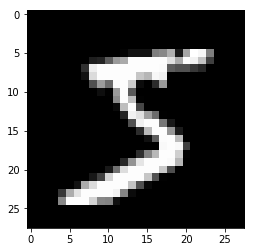

In [4]:
# Show an image
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
x_train.shape

## PyTorch

In [5]:
import torch

# Convert NumPy arrays to torch tensors
trn_X, trn_y, tst_X, tst_y = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

# trn_X = trn_X.type('torch.FloatTensor')
# trn_y = trn_y.type('torch.FloatTensor')
# tst_X = tst_X.type('torch.FloatTensor')
# tst_y = tst_y.type('torch.FloatTensor')

In [6]:
type(trn_X)

torch.Tensor

### Create a neural network from scratch

In [7]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
# trailing _'s in PyTorch signifies an in-place operation
weights.requires_grad_()
# bias: kind of like a coefficient added to each term
bias = torch.zeros(10, requires_grad=True)
weights

tensor([[ 0.0069,  0.0026,  0.0495,  ..., -0.0073,  0.0415,  0.0013],
        [-0.0516, -0.0104,  0.0341,  ..., -0.0298, -0.0179, -0.0624],
        [-0.0097, -0.0148, -0.0373,  ...,  0.0172, -0.0593, -0.0009],
        ...,
        [-0.0255,  0.0367, -0.0128,  ...,  0.0091, -0.0792,  0.0526],
        [-0.0180, -0.0627, -0.0251,  ..., -0.1057, -0.0212, -0.0188],
        [-0.0221,  0.0251, -0.0326,  ...,  0.0263,  0.0216,  0.0528]],
       requires_grad=True)

In [8]:
# Activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

log_softmax(torch.tensor([0.0, 1.0]))

tensor([-1.3133, -0.3133])

In [9]:
# Example to understand log_softmax
test_tensor = torch.tensor([[1., 2, 3], [4, 5, 6]])
print(test_tensor.shape)
print(test_tensor.exp())
print(test_tensor.exp().sum(-1))
print(test_tensor.exp().sum(-1).log())
print(test_tensor.exp().sum(-1).unsqueeze(-1))
print(test_tensor - test_tensor.exp().sum(-1).unsqueeze(-1))

torch.Size([2, 3])
tensor([[  2.7183,   7.3891,  20.0855],
        [ 54.5982, 148.4132, 403.4288]])
tensor([ 30.1929, 606.4401])
tensor([3.4076, 6.4076])
tensor([[ 30.1929],
        [606.4401]])
tensor([[ -29.1929,  -28.1929,  -27.1929],
        [-602.4401, -601.4401, -600.4401]])


In [10]:
# Model for learning
def model(batch):
    return log_softmax(batch @ weights + bias)
# Note: @ is the dot product operation

In [11]:
# Check to make sure dimensions line up
trn_X.shape, weights.shape, bias.shape

(torch.Size([50000, 784]), torch.Size([784, 10]), torch.Size([10]))

In [12]:
batch_size = 64

batch = trn_X[0:batch_size]
predictions = model(batch)
predictions[0], predictions.shape

(tensor([-2.2244, -2.3621, -2.3954, -2.1655, -2.1884, -2.2332, -2.5404, -2.2558,
         -2.4577, -2.2702], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [13]:
# Loss function: the higher, the worse the model performs
def neg_log_likelihood(predictions, target):
    return -predictions[range(target.shape[0]), target].mean()

loss_function = neg_log_likelihood

In [14]:
print(predictions.shape, trn_y[0:batch_size].shape)
loss_function(predictions, trn_y[0:batch_size])

torch.Size([64, 10]) torch.Size([64])


tensor(2.2985, grad_fn=<NegBackward>)

In [15]:
# Accuracy function
def accuracy(predictions, target):
    preds = torch.argmax(predictions, dim=1)
    return (preds == target).float().mean()

In [16]:
accuracy(predictions, trn_y[0:batch_size])

tensor(0.0938)

#### Training the model

In [17]:
# Train
learning_rate = 0.5
epochs = 2

for epoch in range(epochs):
    # Run through all the data in batches
    for i in range((trn_X.shape[0] - 1) // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        batch_X = trn_X[start:end]
        batch_y = trn_y[start:end]
        predictions = model(batch_X)
        model_loss = loss_function(predictions, batch_y)

        # Calculate gradients on weights and bias
        model_loss.backward()
        # Update weights and bias, but don't calculate gradients for this process
        with torch.no_grad():
            weights -= weights.grad * learning_rate
            bias -= bias.grad * learning_rate
            # Set gradients to zero so gradients are correct for next loop
            weights.grad.zero_()
            bias.grad.zero_()

In [18]:
weights, bias

(tensor([[ 0.0069,  0.0026,  0.0495,  ..., -0.0073,  0.0415,  0.0013],
         [-0.0516, -0.0104,  0.0341,  ..., -0.0298, -0.0179, -0.0624],
         [-0.0097, -0.0148, -0.0373,  ...,  0.0172, -0.0593, -0.0009],
         ...,
         [-0.0255,  0.0367, -0.0128,  ...,  0.0091, -0.0792,  0.0526],
         [-0.0180, -0.0627, -0.0251,  ..., -0.1057, -0.0212, -0.0188],
         [-0.0221,  0.0251, -0.0326,  ...,  0.0263,  0.0216,  0.0528]],
        requires_grad=True),
 tensor([-0.4774,  0.4061,  0.1731, -0.3251,  0.0284,  1.7140, -0.1674,  0.8140,
         -1.8164, -0.3494], requires_grad=True))

In [19]:
# Print loss and accuracy of trained model
loss_function(model(tst_X), tst_y), accuracy(model(tst_X), tst_y)

(tensor(0.2917, grad_fn=<NegBackward>), tensor(0.9180))

### torch.nn.functional

Imported as F, torch.nn.functional contains a lot of activation, loss, and other functions.

In [20]:
import torch.nn.functional as F

# Cross entropy combines log-softmax and neg-log-likelihood
loss_function = F.cross_entropy

# Need new model that doesn't use our custom activation function
def model_functional(batch):
    return batch @ weights + bias

In [21]:
# Loss and accuracy should be the same as before
loss_function(model_functional(tst_X), tst_y), accuracy(model_functional(tst_X), tst_y)

(tensor(0.2917, grad_fn=<NllLossBackward>), tensor(0.9180))

### torch.Module

torch.Module allows us to create cleaner code with classes and other stuff.

In [22]:
from torch import nn

class LogisticClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Using nn.Parameter adds it to the list of returned values from self.parameters()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
        self.learning_rate = 0.5
        self.epochs = 2
        self.loss_function = F.cross_entropy
        
    def forward(self, X):
        return X @ self.weights + self.bias
    
    def fit(self, trn_X, trn_y, batch_size=64):
        for i in range(self.epochs):
            for j in range((trn_X.shape[0] - 1) // batch_size + 1):
                start = j * batch_size
                end = start + batch_size
                batch_X = trn_X[start:end]
                batch_y = trn_y[start:end]
                
                loss = self.loss(batch_X, batch_y)
                loss.backward()
                
                with torch.no_grad():
                    # Returns weights and bias
                    for p in self.parameters():
                        p -= p.grad * self.learning_rate
                    # Equivalent to doing p.grad.zero_() for each parameter
                    self.zero_grad()
                   
    # Equivalent to (from outside the class): loss_function(model(tst_X), tst_y)
    def loss(self, X, y):
        return self.loss_function(self.forward(X), y)
    
    # Equivalent to (from outside the class): accuracy(model(tst_X), tst_y)
    def accuracy(self, X, y):
        return accuracy(self.forward(X), y)

In [23]:
model = LogisticClassifier()
print(loss_function(model(tst_X), tst_y), accuracy(model(tst_X), tst_y))
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

tensor(2.3304, grad_fn=<NllLossBackward>) tensor(0.0976)


(tensor(2.3304, grad_fn=<NllLossBackward>), tensor(0.0976))

In [24]:
# Although model is an object, you can call it as if it were a function
# Behind the scenes, running model() calls the forward method automatically
print(model(tst_X))
model.forward(tst_X)

tensor([[-0.2843, -0.1678,  0.3065,  ..., -0.5095, -0.0750, -0.6615],
        [-0.0355,  0.1091, -0.2781,  ..., -0.4955, -0.3272, -0.2944],
        [ 0.0090, -0.4558,  0.1337,  ..., -0.2369,  0.1668,  0.0087],
        ...,
        [ 0.2790,  0.0827,  0.0225,  ...,  0.0471,  0.2188,  0.0274],
        [ 0.2218, -0.3404,  0.4534,  ..., -0.0184, -0.1911, -0.0554],
        [ 0.5538, -0.3151, -0.0921,  ..., -0.0115, -0.3094, -0.1018]],
       grad_fn=<AddBackward0>)


tensor([[-0.2843, -0.1678,  0.3065,  ..., -0.5095, -0.0750, -0.6615],
        [-0.0355,  0.1091, -0.2781,  ..., -0.4955, -0.3272, -0.2944],
        [ 0.0090, -0.4558,  0.1337,  ..., -0.2369,  0.1668,  0.0087],
        ...,
        [ 0.2790,  0.0827,  0.0225,  ...,  0.0471,  0.2188,  0.0274],
        [ 0.2218, -0.3404,  0.4534,  ..., -0.0184, -0.1911, -0.0554],
        [ 0.5538, -0.3151, -0.0921,  ..., -0.0115, -0.3094, -0.1018]],
       grad_fn=<AddBackward0>)

In [25]:
model.fit(trn_X, trn_y)
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(0.2927, grad_fn=<NllLossBackward>), tensor(0.9179))

### nn.Linear

nn.Linear creates a linear layer for us, so we don't need to manually define weights/bias or the feed-forward algorithm.

In [26]:
# All that has changed are the constructor and the fit method
class LinearLogisticClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
        
        self.learning_rate = 0.5
        self.epochs = 2
        self.loss_function = F.cross_entropy
    
    def forward(self, X):
        # Calls nn.Linear.forward method
        return self.linear(X)
    
    def fit(self, trn_X, trn_y, batch_size=64):
        for i in range(self.epochs):
            for j in range((trn_X.shape[0] - 1) // batch_size + 1):
                start = j * batch_size
                end = start + batch_size
                batch_X = trn_X[start:end]
                batch_y = trn_y[start:end]
                
                loss = self.loss(batch_X, batch_y)
                loss.backward()
                
                with torch.no_grad():
                    # self.parameters() contains self.linear.weight and self.linear.bias
                    for p in self.parameters():
                        p -= p.grad * self.learning_rate
                    self.zero_grad()
                   
    def loss(self, X, y):
        return self.loss_function(self.forward(X), y)
    
    def accuracy(self, X, y):
        return accuracy(self.forward(X), y)

In [27]:
model = LinearLogisticClassifier()
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(2.3434, grad_fn=<NllLossBackward>), tensor(0.1141))

In [28]:
model.fit(trn_X, trn_y)
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(0.2921, grad_fn=<NllLossBackward>), tensor(0.9183))

### torch.optim

With torch.optim, we no longer need to manually update our parameters and gradients

In [29]:
from torch import optim

class OptLinearLogisticClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
        
        # Create optim object for our Linear object's parameters (Note: lr = learning_rate)
        self.opt = optim.SGD(self.parameters(), lr=0.5)
        self.epochs = 2
        self.loss_function = F.cross_entropy
    
    def forward(self, X):
        return self.linear(X)
    
    def fit(self, trn_X, trn_y, batch_size=64):
        for i in range(self.epochs):
            for j in range((trn_X.shape[0] - 1) // batch_size + 1):
                start = j * batch_size
                end = start + batch_size
                batch_X = trn_X[start:end]
                batch_y = trn_y[start:end]
                
                loss = self.loss(batch_X, batch_y)
                loss.backward()

                # Performs the updates to the parameters
                self.opt.step()
                self.opt.zero_grad()
                   
    def loss(self, X, y):
        return self.loss_function(self.forward(X), y)
    
    def accuracy(self, X, y):
        return accuracy(self.forward(X), y)

In [30]:
model = OptLinearLogisticClassifier()
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(2.3050, grad_fn=<NllLossBackward>), tensor(0.1168))

In [31]:
model.fit(trn_X, trn_y)
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(0.2925, grad_fn=<NllLossBackward>), tensor(0.9177))

### torch.utils.data.TensorDataset

TensorDatasets provide an easier way to index over our features and label data.

In [32]:
from torch.utils.data import TensorDataset

train = TensorDataset(trn_X, trn_y)
print(trn_X[0:2], trn_y[0:2])
train[0:2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0])


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0]))

In [33]:
batch_X, batch_y = train[10:12]
batch_X, batch_y

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([3, 5]))

### torch.utils.data.DataLoader

DataLoaders help you load your data in batches instead of manually having to loop through them.

In [34]:
from torch.utils.data import DataLoader

from torch import optim

class DataLoaderClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(784, 10)
        self.opt = optim.SGD(self.parameters(), lr=0.5)
        self.loss_function = F.cross_entropy
        
    def forward(self, X):
        return self.linear(X)
    
    def fit(self, trn_X, trn_y, batch_size=64, epochs=2):
        train = TensorDataset(trn_X, trn_y)
        # Always good to shuffle training data
        loader = DataLoader(train, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):
            for batch_X, batch_y in loader:
                loss = self.loss(batch_X, batch_y)
                loss.backward()

                self.opt.step()
                self.opt.zero_grad()
                   
    def loss(self, X, y):
        return self.loss_function(self.forward(X), y)
    
    def accuracy(self, X, y):
        return accuracy(self.forward(X), y)

In [35]:
model = DataLoaderClassifier()
print(model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y))
model.fit(trn_X, trn_y)
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

tensor(2.3122, grad_fn=<NllLossBackward>) tensor(0.1192)


(tensor(0.2993, grad_fn=<NllLossBackward>), tensor(0.9148))

In [36]:
# model.train() and model.eval() set whether in training or validation mode
# Inside your fit method or class, can change behavior based on self.training (Bool)
print(model.training)
model.eval()
print(model.training)
model.train()
model.training

True
False


True

### Convolutional Neural Networks

Helpful guide to understanding CNN's: http://cs231n.github.io/convolutional-networks/

Note: with convolutional layers, the width and height of the output layer is the following:  
`(W - F + 2 * P) / S + 1`  
Where W = input dimensions, F = filter size, P = zero padding, and S = stride size.  
e.g. 7x7 input matrix with a 3x3 filter, stride of 1, and no zero padding
(7 - 3 + 2 * 0) / 1 + 1 = 5x5 output layer

In [37]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        """
        Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)
        in_channels = depth of input (e.g. RGB images would have three channels)
        out_channels = depth of output (i.e. number of filters)
        kernel_size = size of filters (e.g. kernel_size=3 produces a 3x3 filter, (2, 3) a 2x3 filter)
        stride = how many indices to "slide" when convolving/doing dot products of input layer with filters
        padding = number of rows/cols of 0's to pad the input layer with (along width and height dims)
        
        Visualize parameters: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        
        """
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, 3, stride=2, padding=1)
        
        # Momentum: increases converge rates using the physics idea of rolling down a hill
        # Explanation: http://cs231n.github.io/neural-networks-3/#sgd and CTRL+F "momentum"
        self.opt = optim.SGD(self.parameters(), lr=0.1, momentum=0.9)
        
        self.epochs = 2
        self.loss_function = F.cross_entropy
        
    def forward(self, X):        
        # Reshape X to be one column of 28x28 images
        # X's shape is (number of rows, depth, width, height)
        X = X.view(-1, 1, 28, 28)
        
        # ReLU: set X = max(0, X)
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        
        # Pooling layer; 4 is the kernel_size parameter
        X = F.max_pool2d(X, 4)

        # Convert X from 4D tensor back to 2D
        return X.view(-1, X.size(1))
    
    def fit(self, X, y, batch_size=64):
        train = TensorDataset(X, y)
        loader = DataLoader(train, batch_size=batch_size)
        for epoch in range(self.epochs):
            for batch_X, batch_y in loader:
                self.opt.zero_grad()
                
                loss = self.loss(batch_X, batch_y)
                loss.backward()
                
                self.opt.step()
            
    def loss(self, X, y):
        return self.loss_function(self.forward(X), y)
    
    def accuracy(self, X, y):
        return accuracy(self.forward(X), y)

In [38]:
# Visualize transformation of X through CNN: 

X = trn_X[0:64]
model = CNN()
print(X.shape)
        
X = X.view(-1, 1, 28, 28)
print(X.shape)

X = F.relu(model.conv1(X))
print(X.shape)

X = F.relu(model.conv2(X))
print(X.shape)

X = F.relu(model.conv3(X))
print(X.shape)

X = F.max_pool2d(X, 4)
print(X.shape)

X = X.view(-1, X.size(1))
print(X.shape)

torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 16, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 10, 4, 4])
torch.Size([64, 10, 1, 1])
torch.Size([64, 10])


In [39]:
model = CNN()
print(model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y))
model.fit(trn_X, trn_y)
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

tensor(2.3043, grad_fn=<NllLossBackward>) tensor(0.0870)


(tensor(0.2844, grad_fn=<NllLossBackward>), tensor(0.9105))

### nn.Sequential

Simplifies the process of having multiple layers in your neural network.

In [40]:
# Helper class to define custom action for Sequential
class Lambda(nn.Module):
    
    def __init__(self, function):
        super().__init__()
        self.function = function
        
    def forward(self, X):
        return self.function(X)

In [41]:
# Copy methods to use as utility functions
def loss(model, X, y):
    return F.cross_entropy(model.forward(X), y)

def acc(model, X, y):
    return accuracy(model.forward(X), y)

def fit(model, X, y, batch_size=64, learning_rate=0.1, epochs=2):
    opt = optim.SGD(model.parameters(), lr=learning_rate)
    train = TensorDataset(X, y)
    loader = DataLoader(train, batch_size=batch_size)
    for epoch in range(epochs):
        for batch_X, batch_y in loader:
            opt.zero_grad()

            loss_val = loss(model, batch_X, batch_y)
            loss_val.backward()

            opt.step()

In [42]:
model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, 28, 28)),
    nn.Conv2d(1, 16, 3, 2, 1),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, 2, 1),
    nn.ReLU(),
    nn.Conv2d(16, 10, 3, 2, 1),
    nn.ReLU(),
    nn.MaxPool2d(4),
    # Note: we can also use the following line to pool the results to a size of 1x1
    # nn.AdaptiveMaxPool2d(1)
    # Where the argument 1 specifies the size of the output tensor
    Lambda(lambda x: x.view(-1, x.size(1)))
)

print(loss(model, tst_X, tst_y), acc(model, tst_X, tst_y))
fit(model, trn_X, trn_y)
loss(model, tst_X, tst_y), acc(model, tst_X, tst_y)

tensor(2.3035, grad_fn=<NllLossBackward>) tensor(0.1011)


(tensor(0.5012, grad_fn=<NllLossBackward>), tensor(0.8387))

### GPU

If you have a CUDA-capable GPU, you can run tasks on there to speed them up.

In [43]:
torch.cuda.is_available()

False

In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [45]:
# Ways to move a tensor to GPU
cuda_tensor = torch.ones(5, device=device)  # Most efficient
cuda_tensor = cuda_tensor.to(device)  # Most convenient
# cuda_tensor = cuda_tensor.cuda()  # Less useful

In [46]:
# Can send both input tensors and models to GPU
model = model.to(device)
trn_X, trn_y = trn_X.to(device), trn_y.to(device)